# Music Genre Classification with Neural Networks

We will explore the following:
    1. Preprocessing 
    2. Baseline Model
    3. Model Evaluation 
    4. Finetuning Model
        a) L1 and L2 Regularization 
        b) Drop-out Regularization

## 1. Preprocessing 

In [1]:
# import all necessary libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score, f1_score, classification_report, confusion_matrix
import util
from util import plot_confusion_matrix

In [2]:
# load the 3-second variation of the dataset and create a pandas dataframe
path_3_sec = ('../Data/features_3_sec.csv')
path_30_sec = ('../Data/features_3_sec.csv')
df = pd.read_csv(path_3_sec)
df = df.drop(['filename','length'], axis=1)

df.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,1.080790e+06,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,6.722448e+05,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,7.907127e+05,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,9.216524e+05,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,6.102111e+05,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [3]:
#Before Applying one hot encoding, store the original labels
y_original = df["label"]
unique_labels = y_original.unique()
unique_labels

array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock'], dtype=object)

In [4]:
#Apply one-hot encoding to labels 
enc = OneHotEncoder(sparse=False)
y = enc.fit_transform(df[["label"]])
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [5]:
# apply min max scalar to scale values from 1-10
minmaxscalar = preprocessing.MinMaxScaler()
df.loc[:, df.columns != 'label'] = minmaxscalar.fit_transform(df.loc[:, df.columns != 'label'])

df.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,0.355399,0.716757,0.293133,0.107955,0.262173,0.034784,0.459205,0.094130,0.346153,0.083164,...,0.056198,0.397172,0.066062,0.371828,0.055344,0.380831,0.026797,0.506746,0.047781,blues
1,0.367322,0.670347,0.253040,0.044447,0.270969,0.018716,0.470831,0.052261,0.363722,0.051694,...,0.092912,0.351681,0.074001,0.362068,0.076365,0.418452,0.082414,0.593029,0.065548,blues
2,0.373159,0.728067,0.296753,0.141663,0.265293,0.023073,0.494051,0.059922,0.378215,0.060820,...,0.096704,0.420979,0.050639,0.400536,0.067509,0.433742,0.043841,0.546264,0.036062,blues
3,0.399349,0.677066,0.298024,0.075042,0.238427,0.023187,0.455246,0.066234,0.329587,0.070906,...,0.067995,0.387474,0.050617,0.380430,0.050030,0.405824,0.041898,0.562204,0.034873,blues
4,0.355668,0.689113,0.322308,0.052149,0.233460,0.016451,0.451651,0.047830,0.318453,0.046916,...,0.042500,0.460314,0.083860,0.388590,0.076524,0.409019,0.020763,0.517913,0.031713,blues


In [6]:
#split data into 70:10:20 % for training, validation, and testing 

x,y = (df.iloc[:,df.columns != "label"],y)
X_train, X_test, y_train, y_test = train_test_split(x, y,test_size=0.30)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test,test_size=0.33)

print(X_test.shape,y_test.shape)

(2007, 57) (2007, 10)


##  Baseline Model

In [7]:
import tensorflow as tf
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(512, activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(256, activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(128, activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(64, activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(16, activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(10, activation = tf.nn.softmax))

model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy',
             metrics=['accuracy'])

model.fit(X_train, y_train, epochs=50, validation_data = (X_valid,y_valid))


Epoch 1/50
219/219 [==============================] - 2s 4ms/step - loss: 1.7681 - accuracy: 0.3534 - val_loss: 1.4600 - val_accuracy: 0.4909
Epoch 2/50
219/219 [==============================] - 1s 4ms/step - loss: 1.3521 - accuracy: 0.4981 - val_loss: 1.2990 - val_accuracy: 0.5172
Epoch 3/50
219/219 [==============================] - 1s 4ms/step - loss: 1.2043 - accuracy: 0.5477 - val_loss: 1.1885 - val_accuracy: 0.5525
Epoch 4/50
219/219 [==============================] - 1s 4ms/step - loss: 1.1079 - accuracy: 0.5942 - val_loss: 1.0652 - val_accuracy: 0.5970
Epoch 5/50
219/219 [==============================] - 1s 4ms/step - loss: 1.0413 - accuracy: 0.6231 - val_loss: 1.0992 - val_accuracy: 0.5949
Epoch 6/50
219/219 [==============================] - 1s 3ms/step - loss: 0.9539 - accuracy: 0.6514 - val_loss: 0.9397 - val_accuracy: 0.6586
Epoch 7/50
219/219 [==============================] - 1s 3ms/step - loss: 0.8681 - accuracy: 0.6898 - val_loss: 0.9249 - val_accuracy: 0.6586
Epoch 

## Model Evaluation

Evaluation of the models will consist of:
    1. Accuracy vs Epochs on Validation and Training Sets
    2. Loss vs Epochs on Validation and Training Sets
    3. Accuracy 
    4. Precision
    5. Recall 
    6. Confusion Matric 

In [8]:
hist_baseline = model.history

In [9]:
def plot_acc_err(hist):
    plt.figure(figsize=(20,15))
    fig, axs = plt.subplots(2)
    axs[0].plot(hist.history["accuracy"], label="train accuracy")
    axs[0].plot(hist.history["val_accuracy"], label="test accuracy")    
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")
    print("\n")
    # Error 
    axs[1].plot(hist.history["loss"], label="train error")
    axs[1].plot(hist.history["val_loss"], label="test error")    
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

<Figure size 1440x1080 with 0 Axes>

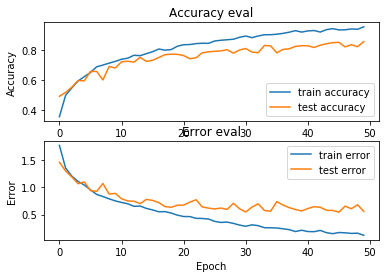

In [10]:
#1. Accuracy vs Epochs on Validation and Training Sets
#2. Loss vs Epochs on Validation and Training Sets
plot_acc_err(hist_baseline)

In [11]:
#evaluate accuracy on the test set 
model.evaluate(X_test,y_test)

63/63 [==============================] - 0s 2ms/step - loss: 0.5017 - accuracy: 0.8724


[0.5017038583755493, 0.8724464178085327]

201/201 [==============================] - 0s 992us/step
              precision    recall  f1-score   support

           0       0.94      0.79      0.86       205
           1       0.90      0.98      0.94       202
           2       0.84      0.82      0.83       182
           3       0.83      0.86      0.85       183
           4       0.92      0.82      0.87       225
           5       0.88      0.87      0.88       204
           6       0.88      0.94      0.90       203
           7       0.87      0.90      0.88       189
           8       0.87      0.93      0.90       201
           9       0.80      0.82      0.81       213

   micro avg       0.87      0.87      0.87      2007
   macro avg       0.87      0.87      0.87      2007
weighted avg       0.87      0.87      0.87      2007

Confusion matrix, without normalization
[[162   0   7   1   2  14   9   0   4   6]
 [  0 198   0   1   1   1   0   0   0   1]
 [  3   1 150   4   0   7   0   5   5   7]
 [  2   1   2 1

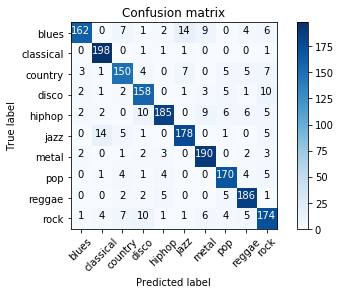

In [13]:
predictions = model.predict(X_test, batch_size=10, verbose=True)
preds = np.argmax(predictions,axis=1)
label = np.argmax(y_test,axis=1)
print(classification_report(label,preds))

cm = confusion_matrix(y_true=label,y_pred=preds)
label = list(unique_labels)
plot_confusion_matrix(cm, label,title='Confusion matrix',save="CM_NN_Baseline")

## Model Finetuning 

### L1 and L2 regularization

In [14]:
model = keras.Sequential()

from tensorflow.keras import regularizers

model.add(keras.layers.Dense(512, activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-3)))
model.add(keras.layers.Dense(256, activation = 'relu' , kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-3)))
model.add(keras.layers.Dense(128, activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-3)))
model.add(keras.layers.Dense(64, activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-3)))
model.add(keras.layers.Dense(16, activation = 'relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-3)))
model.add(keras.layers.Dense(10, activation = 'softmax', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-3)))

model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy',
             metrics=['accuracy'])

model.fit(X_train, y_train, epochs=50, validation_data = (X_valid,y_valid))

Epoch 1/50
219/219 [==============================] - 2s 4ms/step - loss: 2.1198 - accuracy: 0.3353 - val_loss: 1.7084 - val_accuracy: 0.4616
Epoch 2/50
219/219 [==============================] - 1s 4ms/step - loss: 1.5845 - accuracy: 0.4979 - val_loss: 1.5147 - val_accuracy: 0.5061
Epoch 3/50
219/219 [==============================] - 1s 4ms/step - loss: 1.4575 - accuracy: 0.5434 - val_loss: 1.5711 - val_accuracy: 0.5091
Epoch 4/50
219/219 [==============================] - 1s 4ms/step - loss: 1.3963 - accuracy: 0.5679 - val_loss: 1.3844 - val_accuracy: 0.5960
Epoch 5/50
219/219 [==============================] - 1s 4ms/step - loss: 1.3482 - accuracy: 0.5874 - val_loss: 1.3879 - val_accuracy: 0.5576
Epoch 6/50
219/219 [==============================] - 1s 6ms/step - loss: 1.2961 - accuracy: 0.6092 - val_loss: 1.3194 - val_accuracy: 0.6131
Epoch 7/50
219/219 [==============================] - 1s 5ms/step - loss: 1.2943 - accuracy: 0.6112 - val_loss: 1.2824 - val_accuracy: 0.6374
Epoch 

<Figure size 1440x1080 with 0 Axes>

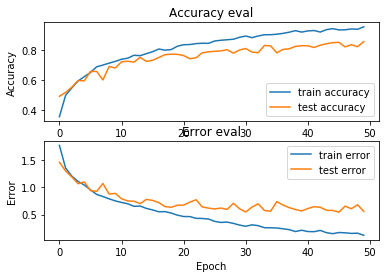

In [15]:
hist_l2_l1 = model.history
plot_acc_err(hist_baseline)

201/201 [==============================] - 0s 997us/step
              precision    recall  f1-score   support

           0       0.87      0.80      0.84       205
           1       0.91      0.98      0.94       202
           2       0.72      0.75      0.74       182
           3       0.62      0.85      0.72       183
           4       0.94      0.58      0.72       225
           5       0.91      0.78      0.84       204
           6       0.78      0.95      0.86       203
           7       0.79      0.85      0.82       189
           8       0.78      0.83      0.80       201
           9       0.65      0.54      0.59       213

   micro avg       0.79      0.79      0.79      2007
   macro avg       0.80      0.79      0.79      2007
weighted avg       0.80      0.79      0.78      2007

Confusion matrix, without normalization
[[165   0   8   4   1   7  10   0   4   6]
 [  0 197   1   0   0   2   0   0   0   2]
 [  7   0 136   4   0   2   2   1   6  24]
 [  1   2   0 1

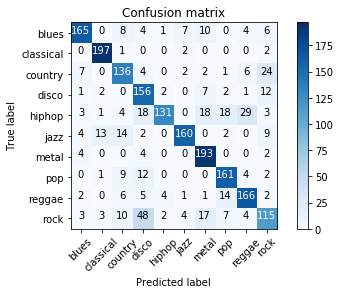

In [16]:
predictions = model.predict(X_test, batch_size=10, verbose=True)
preds = np.argmax(predictions,axis=1)
label = np.argmax(y_test,axis=1)
print(classification_report(label,preds))
cm = confusion_matrix(y_true=label,y_pred=preds)
label = list(unique_labels)
plot_confusion_matrix(cm, label,title='Confusion matrix',save="CM_NN_L1L2")

### Dropout Regularization and He Intialization

In [17]:
model = keras.Sequential()

model.add(keras.layers.Dense(512, activation = "relu",kernel_initializer="he_normal"))

model.add(keras.layers.Dropout(0.3))

model.add(keras.layers.Dense(256, activation = "relu", kernel_initializer="he_normal"))

model.add(keras.layers.Dropout(0.1))

model.add(keras.layers.Dense(128, activation = "relu", kernel_initializer="he_normal"))

model.add(keras.layers.Dropout(0.1))

model.add(keras.layers.Dense(64, activation = "relu", kernel_initializer="he_normal"))


model.add(keras.layers.Dense(10, activation = "softmax"))

model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy',
             metrics=['accuracy'])

model.fit(X_train, y_train, epochs=60, validation_data = (X_valid,y_valid))

Epoch 1/60
219/219 [==============================] - 1s 4ms/step - loss: 1.6637 - accuracy: 0.3854 - val_loss: 1.2633 - val_accuracy: 0.5343
Epoch 2/60
219/219 [==============================] - 1s 3ms/step - loss: 1.2376 - accuracy: 0.5404 - val_loss: 1.0493 - val_accuracy: 0.6192
Epoch 3/60
219/219 [==============================] - 1s 3ms/step - loss: 1.0975 - accuracy: 0.6013 - val_loss: 0.9740 - val_accuracy: 0.6576
Epoch 4/60
219/219 [==============================] - 1s 3ms/step - loss: 0.9935 - accuracy: 0.6402 - val_loss: 0.9127 - val_accuracy: 0.6889
Epoch 5/60
219/219 [==============================] - 1s 3ms/step - loss: 0.9268 - accuracy: 0.6678 - val_loss: 0.9084 - val_accuracy: 0.6848
Epoch 6/60
219/219 [==============================] - 1s 4ms/step - loss: 0.8617 - accuracy: 0.6940 - val_loss: 0.7561 - val_accuracy: 0.7455
Epoch 7/60
219/219 [==============================] - 1s 4ms/step - loss: 0.8194 - accuracy: 0.7097 - val_loss: 0.7890 - val_accuracy: 0.7192
Epoch 

219/219 [==============================] - 1s 4ms/step - loss: 0.1638 - accuracy: 0.9402 - val_loss: 0.4312 - val_accuracy: 0.8747
Epoch 59/60
219/219 [==============================] - 1s 4ms/step - loss: 0.1746 - accuracy: 0.9359 - val_loss: 0.3782 - val_accuracy: 0.8909
Epoch 60/60
219/219 [==============================] - 1s 4ms/step - loss: 0.1556 - accuracy: 0.9442 - val_loss: 0.4025 - val_accuracy: 0.8919


<Figure size 1440x1080 with 0 Axes>

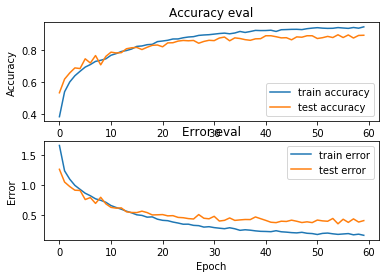

In [18]:
hist_dropout = model.history
plot_acc_err(hist_dropout)

201/201 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       205
           1       0.95      0.97      0.96       202
           2       0.90      0.82      0.86       182
           3       0.89      0.89      0.89       183
           4       0.97      0.87      0.92       225
           5       0.85      0.95      0.89       204
           6       0.95      0.94      0.95       203
           7       0.90      0.91      0.91       189
           8       0.92      0.93      0.92       201
           9       0.82      0.85      0.84       213

   micro avg       0.90      0.90      0.90      2007
   macro avg       0.90      0.90      0.90      2007
weighted avg       0.91      0.90      0.90      2007

Confusion matrix, without normalization
[[188   0   0   0   0  10   2   0   1   4]
 [  0 195   0   0   0   6   0   0   0   1]
 [ 10   0 149   1   0  11   0   1   4   6]
 [  3   2   1 163

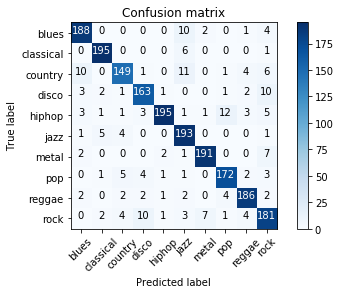

In [21]:
predictions = model.predict(X_test, batch_size=10, verbose=True)
preds = np.argmax(predictions,axis=1)
label = np.argmax(y_test,axis=1)
print(classification_report(label,preds))
cm = confusion_matrix(y_true=label,y_pred=preds)
label = list(unique_labels)
plot_confusion_matrix(cm, label,title='Confusion matrix',save="CM_NN_Dropout")

In [20]:
model.evaluate(X_test,y_test)

63/63 [==============================] - 0s 2ms/step - loss: 0.3225 - accuracy: 0.9033


[0.3225364089012146, 0.9033383131027222]